This notebook was created by Donna Faith Go.

In [1]:
# import sys
# !{sys.executable} -m pip install dtw-python

In [2]:
# standard imports
import matplotlib.pyplot as plt
import pandas as pd 
import pickle
import numpy as np
import seaborn as sns
from typing import Tuple

# webscraping
import requests
from bs4 import BeautifulSoup

# data gathering
import yfinance as yf
import time
import pandas_datareader.data as web
from datetime import datetime, timedelta

# statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

# GARCH model
from arch import arch_model
from sklearn.preprocessing import StandardScaler

# hidden markov models
from hmmlearn.hmm import GaussianHMM

# ClaSP
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.data_loader import load_tssb_dataset

# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Experiments with the VIX

In this notebook, I do experiments with the VIX and the ^GSPC to check if there is anything that would be interesting for our research project.

### Data Gathering

In [3]:
# getting closing prices for the 30 stocks with batching
start_date = '2000-01-01'
end_date = '2026-01-01'

def download_stocks_in_batches(tickers, batch_size=5, delay=1):
    """
    Download stock data in batches to avoid rate limiting
    """
    all_data = {}
    
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"Downloading batch {i//batch_size + 1}: {batch}")
        
        try:
            # Download the batch
            batch_data = yf.download(
                batch,
                start=start_date,
                end=end_date,
                progress=False
            )
            
            # Extract closing prices for this batch
            if not batch_data.empty and 'Close' in batch_data.columns:
                closes = batch_data['Close']
                if isinstance(closes, pd.Series):
                    all_data[batch[0]] = closes
                else:
                    for ticker in closes.columns:
                        all_data[ticker] = closes[ticker]
                print(f"Successfully downloaded {len(batch)} stocks")
            else:
                print(f"No data returned for batch: {batch}")
            
        except Exception as e:
            print(f"Error downloading batch {batch}: {e}")
        
        # Add delay to avoid rate limiting
        if i + batch_size < len(tickers):
            print(f"Waiting {delay} seconds before next batch...")
            time.sleep(delay)
    
    if all_data:
        return pd.DataFrame(all_data)
    else:
        return pd.DataFrame()

In [4]:
# # Download the major stock indices
# closing_df = download_stocks_in_batches(
#     major_indices, 
#     batch_size=5, 
#     delay=5
# )

# if not closing_df.empty:
#     closing_df.to_pickle('data/major stock indices.pkl')

In [5]:
# # Download the volatility indices
# closing_df = download_stocks_in_batches(
#     ['^VIX'], 
#     batch_size=5, 
#     delay=5
# )

# if not closing_df.empty:
#     closing_df.to_pickle('data/volatility indices.pkl')

In [6]:
# get the major stock indices data
filepath = r'data/major stock indices.pkl'
with open(filepath, 'rb') as f:
    indices_data = pickle.load(f)

# remove the invalid tickers
indices_data.dropna(how='all', axis=1, inplace=True)

# get gspc data
gspc_data = indices_data[['^GSPC']]

In [7]:
# get the volatility data
filepath = r'data/volatility indices.pkl'
with open(filepath, 'rb') as f:
    volatility_data = pickle.load(f)

### Data Preprocessing

In [8]:
# get log returns
tau_val = 252
log_returns = np.log(gspc_data).diff(tau_val).dropna()
simple_returns = 100 * gspc_data.pct_change().dropna()
gspc_volatility = log_returns.rolling(window=tau_val).std()

In [9]:
# checking for stationarity
p_value = 0.05
adf_res = adfuller(log_returns)[1]
kpss_res = kpss(log_returns)[1]

print("ADF Result:", "Stationary" if adf_res < p_value else "Not Stationary")
print("KPSS Result:", "Stationary" if kpss_res > p_value else "Not Stationary")

ADF Result: Stationary
KPSS Result: Not Stationary


C:\Users\Donna\AppData\Local\Temp\ipykernel_29264\3642093147.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(log_returns)[1]


### GARCH

In [10]:
# creating the model
model = arch_model(log_returns, p=1, q=1, hold_back=10)
model_fit = model.fit()

# predictions
cond_vol = np.sqrt(250.)*model_fit.conditional_volatility

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1039615231.2771052
Iteration:      2,   Func. Count:     21,   Neg. LLF: 4.781689630794883e+16
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1887253701.3187082
Iteration:      4,   Func. Count:     47,   Neg. LLF: 340497820.4551202
Iteration:      5,   Func. Count:     61,   Neg. LLF: 34373.022345001154
Iteration:      6,   Func. Count:     73,   Neg. LLF: 92805204.2534301
Iteration:      7,   Func. Count:     87,   Neg. LLF: 6.687807800924144e+16
Iteration:      8,   Func. Count:     97,   Neg. LLF: -5496.006362327904
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5496.006452488641
            Iterations: 12
            Function evaluations: 97
            Gradient evaluations: 8


C:\Users\Donna\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02701. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


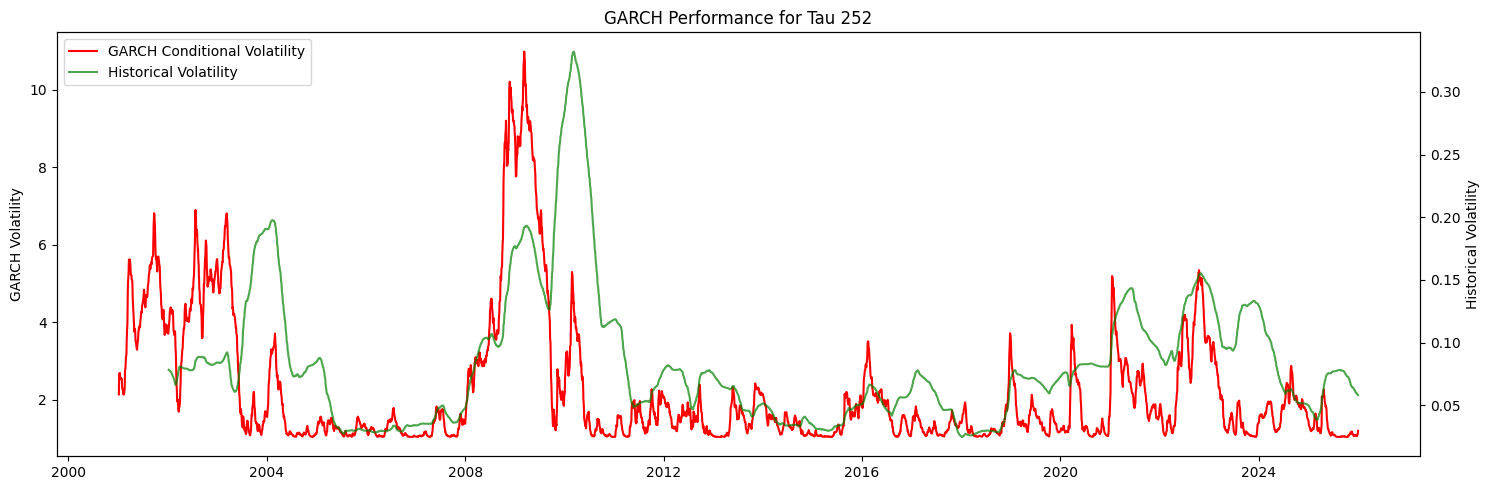

In [11]:
# plotting
plt.figure(figsize=(15, 5))

ax1 = plt.gca()
ax1.plot(
    cond_vol, 
    label='GARCH Conditional Volatility', 
    c='r'
)
ax1.set_ylabel('GARCH Volatility')

ax2 = ax1.twinx()
ax2.plot(
    gspc_volatility, 
    label='Historical Volatility', 
    c='g', 
    alpha=0.7
)
ax2.set_ylabel('Historical Volatility')

plt.title(F'GARCH Performance for Tau {tau_val}')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
plt.tight_layout()
plt.show()

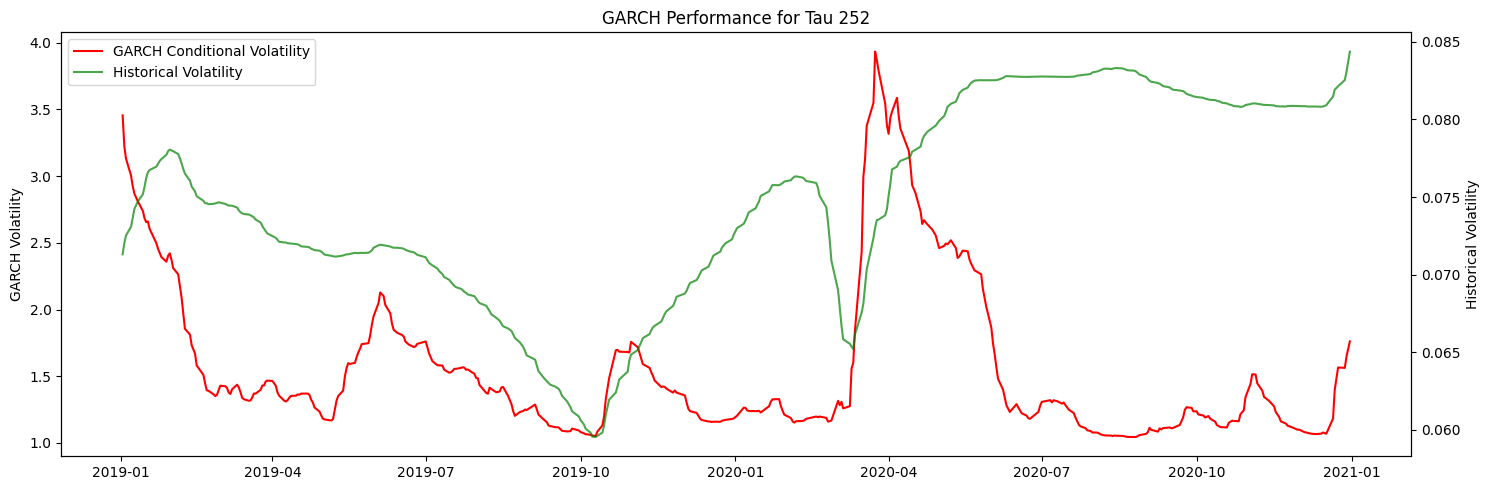

In [12]:
# predictions
cond_vol = np.sqrt(250.)*model_fit.conditional_volatility

# plotting
plt.figure(figsize=(15, 5))

ax1 = plt.gca()
ax1.plot(
    cond_vol.loc['2019':'2020'], 
    label='GARCH Conditional Volatility', 
    c='r'
)
ax1.set_ylabel('GARCH Volatility')

ax2 = ax1.twinx()
ax2.plot(
    gspc_volatility.loc['2019':'2020'], 
    label='Historical Volatility', 
    c='g', alpha=0.7
)
ax2.set_ylabel('Historical Volatility')

plt.title(F'GARCH Performance for Tau {tau_val}')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
plt.tight_layout()
plt.show()

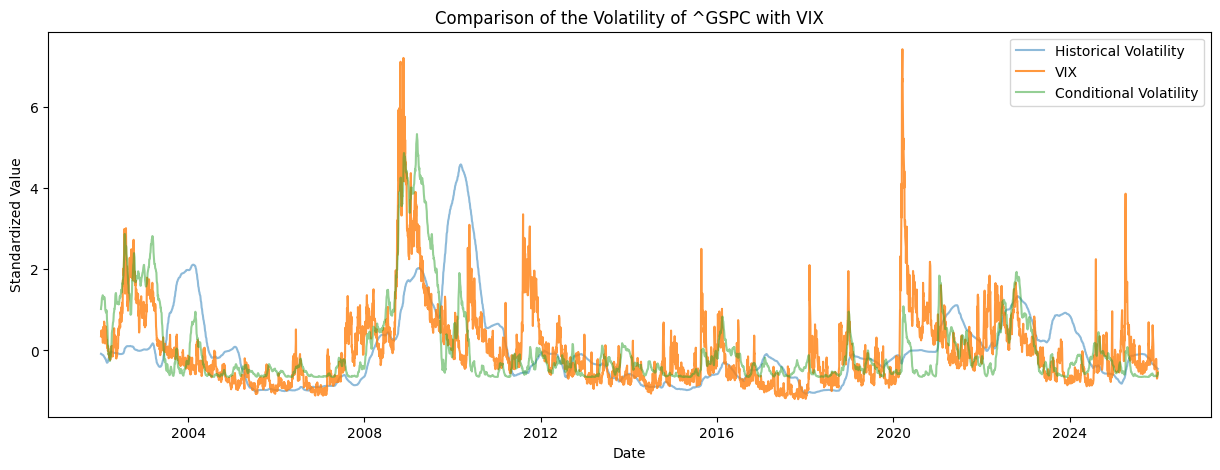

In [13]:
# get plotting dataframe
plot_df = pd.DataFrame(cond_vol)
plot_df['historical volatility'] = gspc_volatility.copy()
plot_df['VIX'] = volatility_data['^VIX'].copy()
plot_df.dropna(how='any', axis=0, inplace=True)

# standardize values
scaler = StandardScaler()
plot_df = pd.DataFrame(
    scaler.fit_transform(plot_df),
    index=plot_df.index,
    columns=plot_df.columns
)

# plotting
plt.figure(figsize=(15, 5))
plt.plot(
    plot_df['historical volatility'], 
    label='Historical Volatility', 
    alpha=0.5
)
plt.plot(
    plot_df['VIX'], 
    label='VIX', 
    alpha=0.8
)
plt.plot(
    plot_df['cond_vol'], 
    label='Conditional Volatility', 
    alpha=0.5
)
plt.ylabel('Standardized Value')
plt.xlabel('Date')
plt.title('Comparison of the Volatility of ^GSPC with VIX')
plt.legend()
plt.show()

### Hidden Markov Model

In [14]:
vix_data = volatility_data[['^VIX']].copy()

# adding more features
vix_data['returns'] = vix_data['^VIX'].diff(1)
vix_data.drop(index='2013-01-02', inplace=True)
vix_data['volatility'] = (
    vix_data['returns']
        .rolling(window=5)
        .std()
)

# feature extraction
features = vix_data[['returns', 'volatility']].dropna()
x = features.values

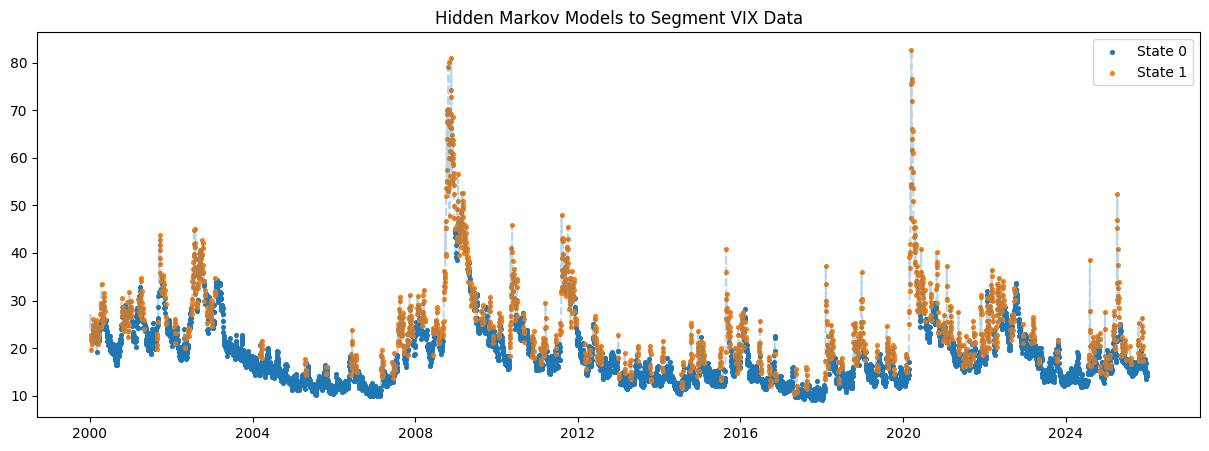

In [15]:
# modelling
model = GaussianHMM(
    n_components = 2, 
    covariance_type = 'full', 
    n_iter = 1000, 
    random_state = 42
)
model.fit(x)
hidden_states = model.predict(x)
features['state'] = hidden_states

# compare to original data
vix_data.loc[features.index, 'state'] = features['state']

# plotting
plt.figure(figsize=(15, 5))

for state in range(model.n_components):
    mask = vix_data['state'] == state
    plt.scatter(
        vix_data.index[mask], 
        vix_data['^VIX'][mask], 
        label=f'State {state}',
        s=7
    )

plt.plot(vix_data['^VIX'], alpha=0.3, linestyle='--')
plt.legend()
plt.title('Hidden Markov Models to Segment VIX Data')
plt.show()

BIC and AIC  
statsmodels  
autoencoders, pca, svm

contextual time series embedding guanchao feng  
model free detection of unique events zsigmond benko

### ClaSP

In [16]:
# # setting up model
# clasp = BinaryClaSPSegmentation(window_size=tau_val)

# # fit predict
# clasp.fit_predict(vix_data['returns'].values)
# clasp.plot(heading="Segmentation of VIX returns", 
#            ts_name="VIX returns")

In [17]:
# # returns as array
# returns = np.asarray(vix_data['returns']).ravel()

# # modelling
# clasp = BinaryClaSPSegmentation(
#     window_size=tau_val, 
#     threshold=0.05
# )
# change_points = clasp.fit_predict(returns)

# # Plot
# # clasp.plot(
# #     ts=returns,
# #     heading="Segmentation of VIX Returns",
# #     ts_name="VIX Returns"
# # )
# clasp.plot(
#     heading="Segmentation of VIX Returns",
#     ts_name="VIX Returns"
# )

### Notes for self

mean field theory: heterogeneity  
hmm variance  

boundary conditions
- reflective = mirror
- null boundaries = zero
- periodic boundary condition = periodic
- unrestrictive = hard to justify

potts model  
heisenberg model